In [68]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import os
from pathlib import Path

### Data exploration

In [ ]:
data = []

for file in Path("data").glob("*.mat"):
    try:
        data.append(loadmat(file))
    except Exception as e:
        print(f"Error loading {file}: {e}")

# uncomment to select different examples

# data_1 = data[0]
# A = data_1['amplitudes1']
# distance = data_1['distances1']
# PC = data_1['cloud1']

# data_1 = data[1]
# A = data_1['amplitudes2']
# distance = data_1['distances2']
# PC = data_1['cloud2']

# data_1 = data[2]
# A = data_1['amplitudes3']
# distance = data_1['distances3']
# PC = data_1['cloud3']

data_1 = data[3]
A = data_1['amplitudes4']
distance = data_1['distances4']
PC = data_1['cloud4']

In [70]:
data_1.keys()

dict_keys(['__header__', '__version__', '__globals__', 'amplitudes4', 'distances4', 'cloud4'])

In [71]:
print(A.shape, distance.shape, A.dtype, distance.dtype)
print(np.nanmin(distance), np.nanmax(distance))

(424, 512) (424, 512) uint16 float64
0.0 10.848221778869629


(np.float64(-0.5), np.float64(511.5), np.float64(423.5), np.float64(-0.5))

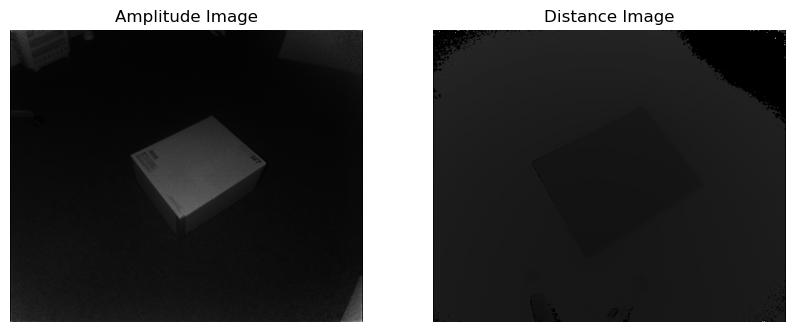

In [72]:
# Visualize distance and amplitude image
fig, ax = plt.subplots(1,2, figsize=(10,5)) 
ax[0].imshow(A, cmap='gray') 
ax[0].set_title('Amplitude Image') 
ax[0].axis('off') 
ax[1].imshow(distance, cmap='gray') 
ax[1].set_title('Distance Image') 
ax[1].axis('off')

The box is visible since its a solid surface and reflecting light well.

Distance image looks almost entirely the same color. Can't really understand the distance that well

In [73]:
print(f"Amplitude range: {A.min()} to {A.max()}")
print(f"Distance range: {distance.min()} to {distance.max()}")

Amplitude range: 0 to 23545
Distance range: 0.0 to 10.848221778869629


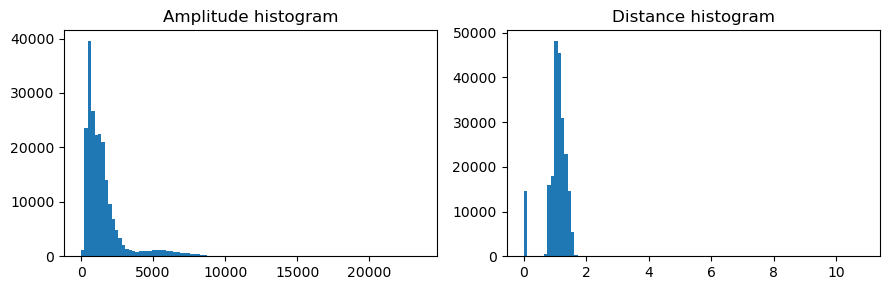

In [74]:
# checking where most pixels lie in distance image
plt.figure(figsize=(9,3))
plt.subplot(1,2,1)
plt.hist(A.ravel(), bins=100, range=(A.min(), A.max()))
plt.title("Amplitude histogram")


plt.subplot(1,2,2)
plt.hist(distance.ravel(), bins=100, range=(distance.min(), distance.max()))
plt.title("Distance histogram")
plt.tight_layout()
plt.show()

Values around zero are not included as the object can't be 0 m away. So it is probably a failed reading

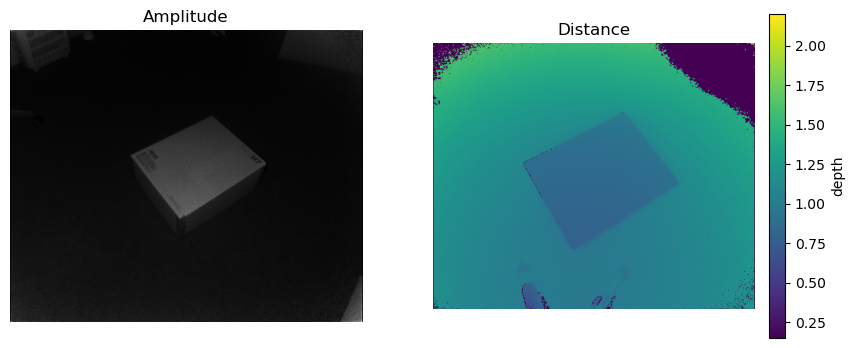

In [75]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].imshow(A, cmap='gray')
ax[0].set_title('Amplitude') 
ax[0].axis('off')

# visualizing distance with with defined vmin and vmax
im = ax[1].imshow(distance, cmap='viridis', vmin=0.15, vmax=2.2)
ax[1].set_title('Distance') 
ax[1].axis('off')
fig.colorbar(im, ax=ax[1], fraction=0.046, pad=0.04, label='depth')


Strong border along the edges which drops in distance. So this might actually be an artifact due to weak signals

### Point cloud plot

In [76]:
# extract pixel value at each space
X = PC[:,:, 0].ravel()
Y = PC[:,:, 1].ravel()
Z = PC[:,:, 2].ravel()

X.shape, Y.shape, Z.shape

((217088,), (217088,), (217088,))

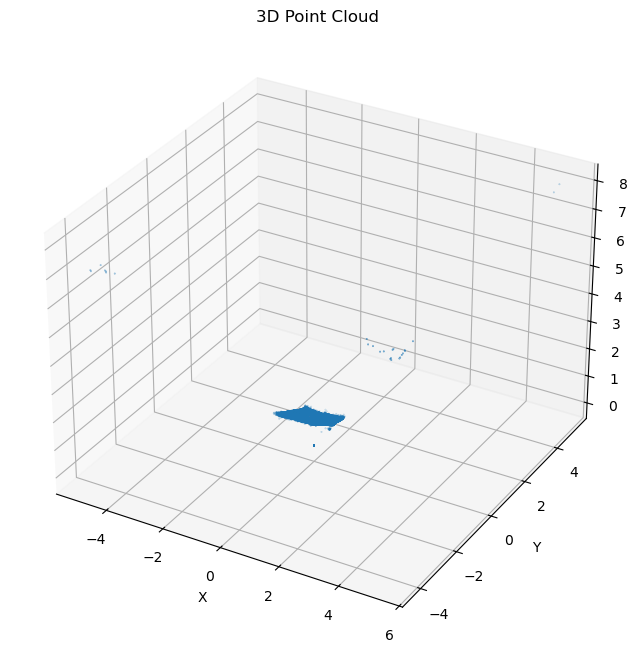

In [77]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X, Y, Z, s=0.1)

ax.set_title('3D Point Cloud')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()


The current point cloud contains a lot of redundant points (background, outliers) which we can clean up with thresholding the amplitude and distance as we are only interested in the point cloud for the box.

### Filtering to remove noise

We want sharper edges and less speckle noise. So first we test out mean and median filters to see how they effect the A and distance images

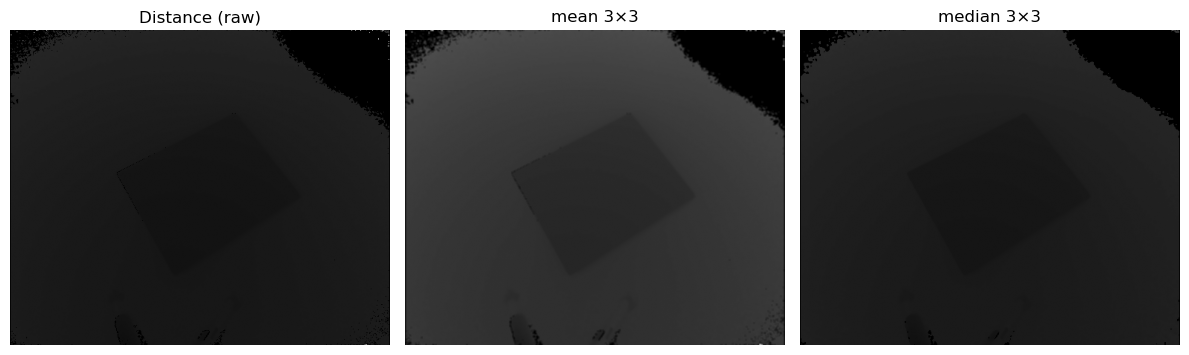

In [78]:
# testing mean and median filters on distance image

from scipy.ndimage import median_filter, uniform_filter

D_mean3 = uniform_filter(distance, size=3)
D_mean5 = uniform_filter(distance, size=5)
D_median3 = median_filter(distance, size=3)   

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

im0 = ax[0].imshow(distance, cmap='grey')
ax[0].set_title("Distance (raw)")
ax[0].axis('off')

ax[1].imshow(D_mean3,  cmap='grey')
ax[1].set_title("mean 3×3")
ax[1].axis('off')

ax[2].imshow(D_median3, cmap='grey')
ax[2].set_title("median 3×3")
ax[2].axis('off')

plt.tight_layout()
plt.show()

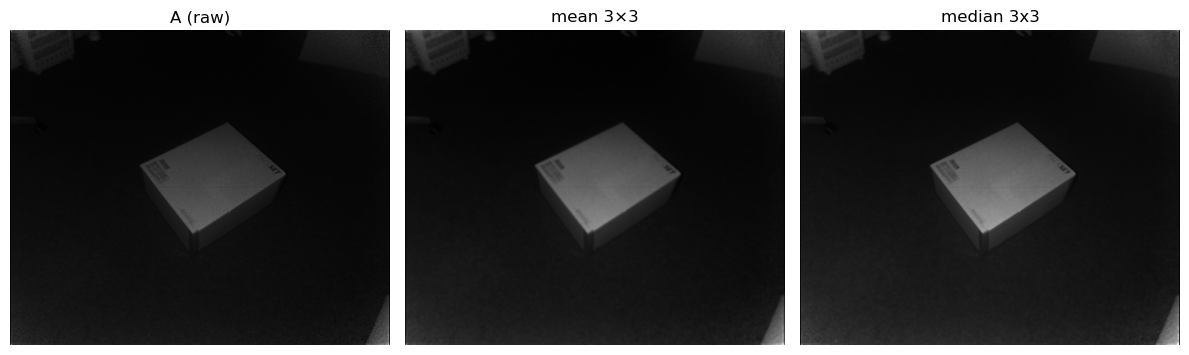

In [79]:
# testing mean and median filters on amplitude image
A_mean3 = uniform_filter(A, size=3)
A_med3 = median_filter(A, size=3)

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

im0 = ax[0].imshow(A, cmap='grey')
ax[0].set_title("A (raw)")   
ax[0].axis('off')

ax[1].imshow(A_mean3,  cmap='grey')
ax[1].set_title("mean 3×3")
ax[1].axis('off')

ax[2].imshow(A_med3, cmap='grey')
ax[2].set_title("median 3x3")
ax[2].axis('off')

plt.tight_layout()
plt.show()

### Data clean up (Invalid/weak signals, extreme distance)

We want to keep the pixels that are 
- have some signal returned
- within a sensible distance

Lots of low amplitudes meaning that the signals here are not reliable. 

We can also ignore the 0 values in the distance data as it suggests missing data 

### Remove nan and negative data

In [80]:
# create a validity mask based on criteria
invalid = (
    ~np.isfinite(PC).all(axis=-1) | # remove NaN in any of the X,Y,Z coords 
    (PC[:, :, 2] == 0) |            #  
    ~np.isfinite(D_median3) |    # remove NaN in distance
    (D_median3 <= 0) |           # remove zero or negative distances
    (A_med3 <= 0)                   # remove zero or negative amplitudes
)

# is True iff that pixel’s XYZ are finite, z!=0, distance>0 and amplitude>0
valid_mask = ~invalid     # pixels to keep
valid_mask.shape

(424, 512)

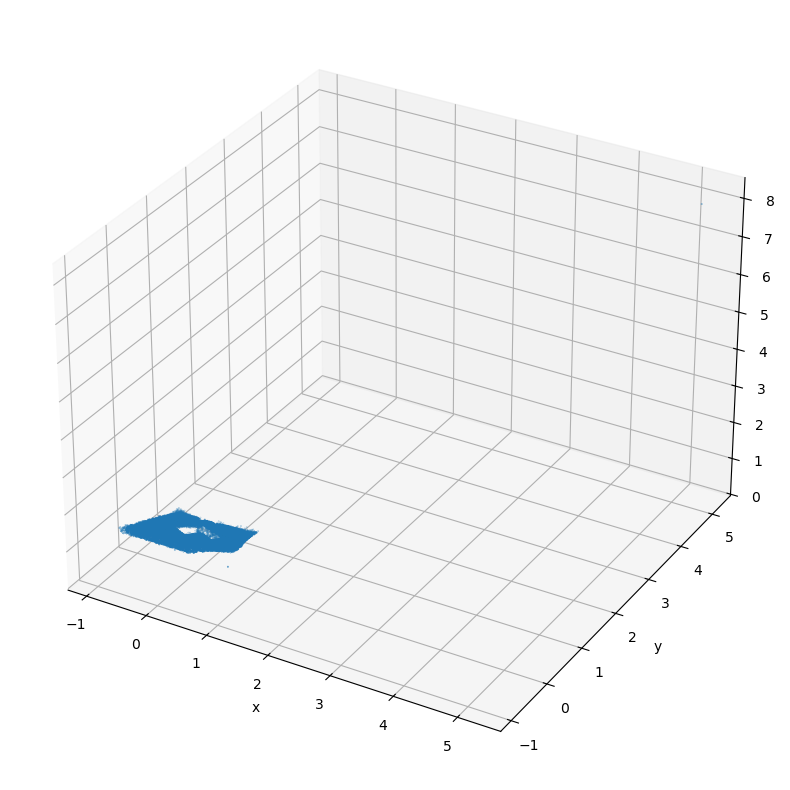

In [81]:
rows, cols = np.where(valid_mask)       # returns the row/col indices of every True pixel in valid_mask
if rows.size == 0:
    print("No points to plot after filtering.")
else:
    # downsample for speed
    sel = np.random.choice(rows.size, min(20_000, rows.size), replace=False)
    rows, cols = rows[sel], cols[sel]

    X = PC[rows, cols, 0]
    Y = PC[rows, cols, 1]
    Z = PC[rows, cols, 2]

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(X, Y, Z, s=0.1)              

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")

    plt.tight_layout()
    plt.show()


### RANSAC

In [82]:
# helper functions
def apply_mask(PC, mask):
    """Applies a defined mask to the point cloud."""
    rows, cols = np.where(mask)
    PC_masked = PC[rows, cols, :].astype(float)
    return PC_masked, rows, cols

def fit_plane(points):
    """ 
    Takes 3 points (3x3 array) and fits a plane. Returns 
    unit normal n and offset d.
    """
    p1, p2, p3 = points
    # form edge vectors
    vec1 = p2 - p1
    vec2 = p3 - p1

    n_raw = np.cross(vec1, vec2)
    normal_len = np.linalg.norm(n_raw)

    # if collinear points, return None
    if normal_len == 0:
        return None, None, False
    
    n = n_raw / normal_len
    d = -float(np.dot(n, p1))
    
    return n, d, True

def calculate_distance(points, n, d):
    """Finds the point to plane distances for multiple points (N,3) at once."""
    values = np.abs(np.dot(points, n) + d)
    return values

def find_inliers(distances, threshold):
    """Finds inliers based on a distance threshold."""
    inliers_mask = distances < threshold
    inliers_idx = np.where(inliers_mask)[0]
    inliers_count = inliers_mask.sum()

    return inliers_mask, inliers_idx, int(inliers_count)

def sample_points(p):
    """ Returns three distinct integers (indices) from 0..p-1"""
    return np.random.choice(p, 3, replace=False)


In [83]:
def RANSAC(PC, max_iter, distance_thresh):
    best_count = -1     # becuase number of inliers can be zero
    best_n = None
    best_d = None
    best_inliers = None

    if PC.shape[0] < 3:
        raise ValueError("Not enough points to fit a plane.")
    
    for iter in range(max_iter):
        points = sample_points(PC.shape[0])
        n, d, valid = fit_plane(PC[points, :])

        # skip collinear points
        if not valid:
            continue

        distances = calculate_distance(PC, n, d)
        inliers, idx, inlier_count = find_inliers(distances, distance_thresh)

        if inlier_count > best_count:
            best_count = inlier_count
            best_n = n
            best_d = d
            best_inliers = inliers
        
    return best_n, best_d, best_inliers, best_count
    

In [84]:
# apply mask to point cloud
P_filtered, rows, cols = apply_mask(PC, valid_mask)   # P_filtered is (N,3)

# run RANSAC
best_n, best_d, best_inlier_mask, best_inlier_count = RANSAC(P_filtered, max_iter=3000, distance_thresh=0.05)
print("best inliers:", best_inlier_count, "of", P_filtered.shape[0])

best inliers: 169859 of 201996


In [85]:
P_filtered.shape

(201996, 3)

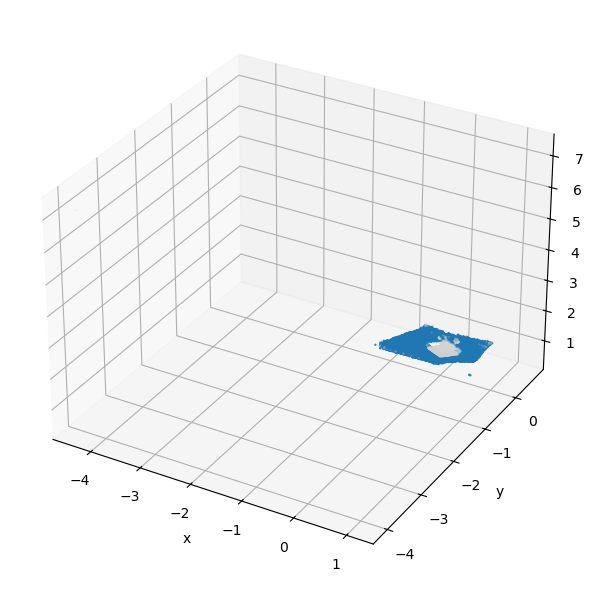

In [86]:
# Randomly select a sub-sample of inliers for plotting
N = P_filtered.shape[0]
sub = np.random.choice(N, min(30_000, N), replace=False)
inlier_sub = best_inlier_mask[sub] 
X, Y, Z = P_filtered[sub,0], P_filtered[sub,1], P_filtered[sub,2]

fig = plt.figure(figsize=(7,6)); ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[~inlier_sub], Y[~inlier_sub], Z[~inlier_sub], s=0.25, c='lightgray', alpha=0.25)
ax.scatter(X[inlier_sub],  Y[inlier_sub],  Z[inlier_sub],  s=0.5,  c='tab:blue', alpha=0.9)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.tight_layout()
plt.show()

### Map and visualize the inliers in the image

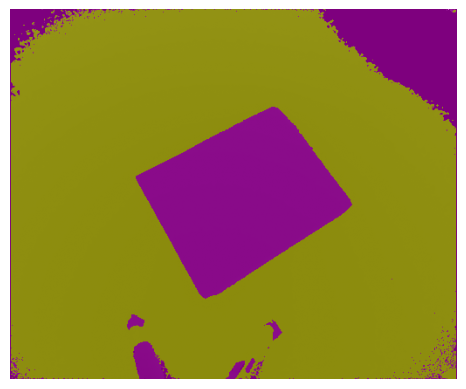

Floor inliers (pixels): 169859 out of 217088


In [87]:
H, W = PC.shape[:2]     # height and width of original image
floor_mask = np.zeros((H, W), dtype=bool)
floor_mask[rows[best_inlier_mask], cols[best_inlier_mask]] = True

# overlay on your filtered distance image
plt.imshow(D_median3, cmap='grey')

# background = False = magenta
# Floor = True = yellow
plt.imshow(floor_mask, cmap='spring', alpha=0.5)
plt.axis('off')
plt.show()
print("Floor inliers (pixels):", floor_mask.sum(), "out of", H*W)

### Morphological operators on masked image

Floor inliers (pixels): 167329 out of 217088


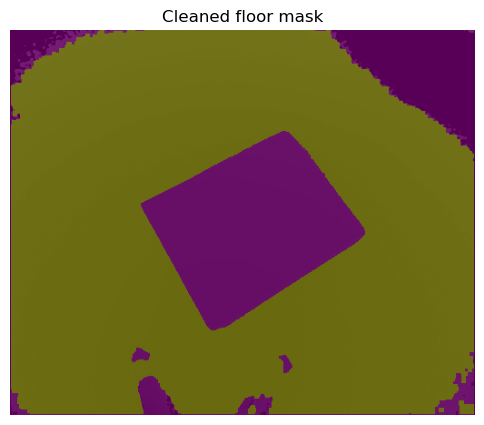

In [88]:
from scipy.ndimage import binary_opening, binary_closing


kernel = np.ones((5,5), dtype=bool)
kernel2 = np.ones((3,3), dtype=bool)
# remove speckles
floor_mask_clean1 = binary_opening(floor_mask, structure=kernel)
# fill holes in foreground
floor_mask_clean = binary_closing(floor_mask_clean1, structure=kernel2)
print("Floor inliers (pixels):", floor_mask_clean.sum(), "out of", H*W)
plt.figure(figsize=(6,6))
plt.imshow(D_median3, cmap='gray')
plt.imshow(floor_mask_clean, cmap='spring', alpha=0.35)
plt.title("Cleaned floor mask")
plt.axis('off')
plt.show()


### Remove the floor inliers and visualize the rest

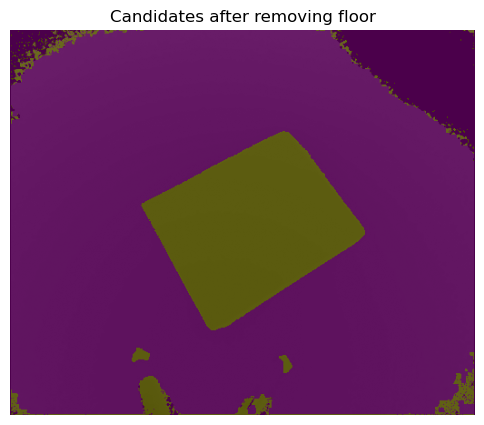

In [89]:
valid0 = np.isfinite(PC).all(axis=2) & (PC[...,2] != 0)
keep_nonfloor = valid0 & ~floor_mask_clean

# Convert back to point list for RANSAC #2
PC2, row2, col2 = apply_mask(PC, keep_nonfloor)

plt.figure(figsize=(6,6))
# colors inverted now, yellow is the non-floor points
plt.imshow(D_median3, cmap='gray')
plt.imshow(keep_nonfloor, cmap='spring', alpha=0.30)
plt.title("Candidates after removing floor")
plt.axis('off')
plt.show()


### Finding the top plane of the box

Top-plane inliers: 27851 of 35180


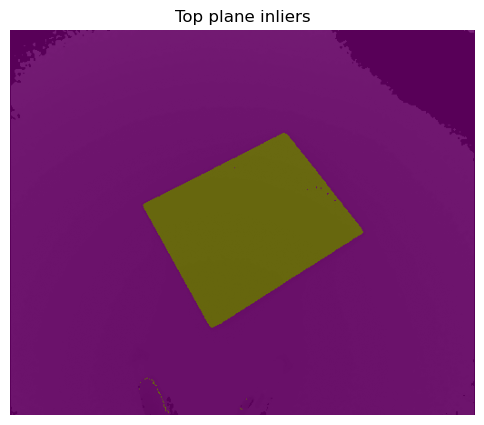

In [90]:
thresh = 0.007 
n_top, d_top, top_in, top_in_count = RANSAC(PC2, max_iter=2000, distance_thresh=thresh)
print("Top-plane inliers:", top_in_count, "of", PC2.shape[0])

# map top inliers to an image mask
top_mask = np.zeros(valid0.shape, dtype=bool)
top_mask[row2[top_in], col2[top_in]] = True

plt.figure(figsize=(6,6))
plt.imshow(D_median3, cmap='gray')
plt.imshow(top_mask, cmap='spring', alpha=0.35)
plt.title("Top plane inliers")
plt.axis('off')
plt.show()


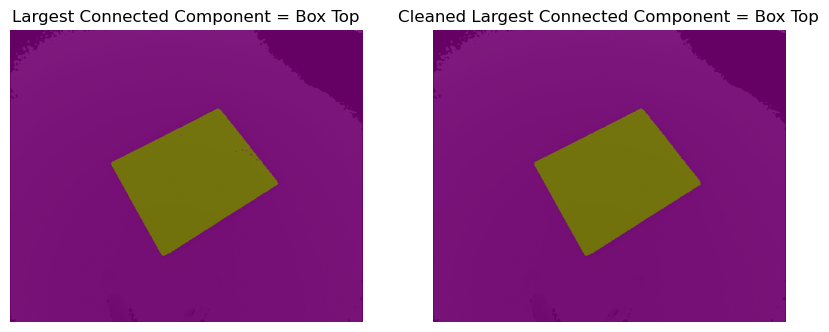

In [91]:
from scipy.ndimage import label


l, num_connected = label(top_mask)    # default 4 connected neighbourhood used
l_sizes = np.bincount(l.ravel())        # flatten l and count how many times each label appears
l_sizes[0] = 0                          # make sure background is ignored
box_top_mask = (l == l_sizes.argmax())  # boolean mask with largest connected component

# light morphological cleanup
ker = np.ones((3,3), bool)
box_top_mask_cleaned = binary_opening(box_top_mask, ker)
box_top_mask_cleaned = binary_closing(box_top_mask_cleaned, ker)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].imshow(D_median3, cmap='gray')
ax[0].imshow(box_top_mask, cmap='spring', alpha=0.40)
ax[0].set_title("Largest Connected Component = Box Top")
ax[0].axis('off')

ax[1].imshow(D_median3, cmap='gray')
ax[1].imshow(box_top_mask_cleaned, cmap='spring', alpha=0.40)
ax[1].set_title("Cleaned Largest Connected Component = Box Top")
ax[1].axis('off')


plt.show()


### Calculate dimensions

In [92]:
# align normals because we assume both planes have the same normal direction
# if the dot product is negative, we flip the normal
if np.dot(n_top, best_n) < 0:
    n_top, d_top = -n_top, -d_top

# perpendicular separation (meters)
height = abs(d_top - best_d)
print("Box height (m):", height)

Box height (m): 0.17749516991641068


In [93]:
# Calculating the length and width of the box
# C1 top left, C2 bottom right, C3 top right, C4 bottom left

rows, cols = np.where(box_top_mask)

# top-left corner (C1)
C1_idx = np.argmin(rows + cols)
C1_2d = (rows[C1_idx], cols[C1_idx])
C1_3d = PC[C1_2d[0], C1_2d[1]]
# bottom-right corner (C2)
C2_idx = np.argmax(rows + cols)
C2_2d = (rows[C2_idx], cols[C2_idx])
C2_3d = PC[C2_2d[0], C2_2d[1]]
# top-right corner (C3)
C3_idx = np.argmin(rows - cols)
C3_2d = (rows[C3_idx], cols[C3_idx])
C3_3d = PC[C3_2d[0], C3_2d[1]]
# bottom-left corner (C4)
C4_idx = np.argmax(rows - cols)
C4_2d = (rows[C4_idx], cols[C4_idx])
C4_3d = PC[C4_2d[0], C4_2d[1]]

# bottom left to bottom right = length
length = np.linalg.norm(C4_3d - C2_3d)
# top left to bottom left = width
width = np.linalg.norm(C1_3d - C4_3d)

# Enforce L >= W (just in case)
if width > length:
    length, width = width, length
    print("Swapped length and width")

print(f"length: {length:.3f}, width: {width:.3f}")


length: 0.444, width: 0.346


### Visualize results

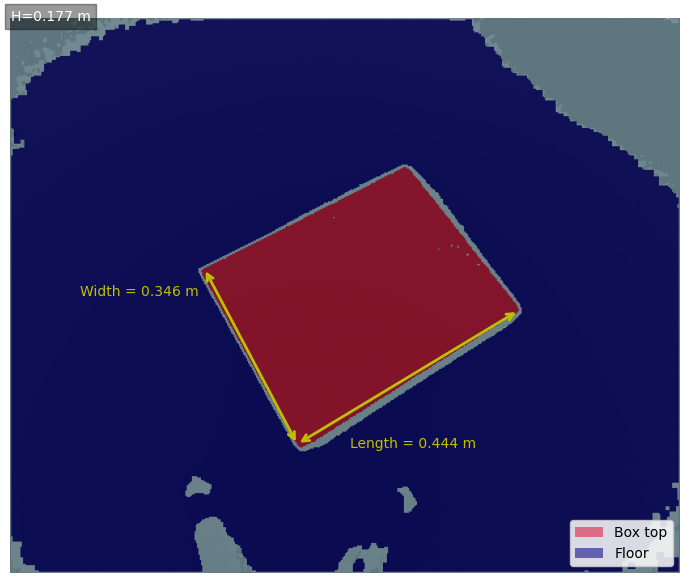

In [94]:
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.patches import FancyArrowPatch

H, W = D_median3.shape
vis = np.zeros((H, W, 3), float)
vis[...]            = mcolors.to_rgb('lightblue')   # background
vis[floor_mask_clean] = mcolors.to_rgb('navy')        # floor
vis[box_top_mask]     = mcolors.to_rgb('crimson')     # box top

plt.figure(figsize=(7,6))
plt.imshow(D_median3, cmap='gray')
plt.imshow(vis, alpha=0.55)


corners_ij = np.array([C1_2d, C2_2d, C3_2d, C4_2d], dtype=int)
xs, ys = corners_ij[:,1], corners_ij[:,0]  # x = cols, y = rows
# C2, C4 - length
L0 = (xs[3], ys[3])
L1 = (xs[1], ys[1])   
# C4, C1 - width
W0 = (xs[0], ys[0])
W1 = (xs[3], ys[3])   

# get the current active plotting axis
ax = plt.gca()

# visualize length and width arrows
ax.add_patch(FancyArrowPatch(L0, L1, arrowstyle="<->", color="y", linewidth=2, mutation_scale=12))
ax.text(L0[0]+40, L0[1]+2, f"Length = {length:.3f} m", color='y', fontsize=10)
ax.add_patch(FancyArrowPatch(W0, W1, arrowstyle="<->", color="y", linewidth=2, mutation_scale=12))
ax.text(W0[0]-95, W0[1]+20, f"Width = {width:.3f} m", color='y', fontsize=10)
ax.text(0.02, 0.98, f"H={height:.3f} m", color='white', bbox=dict(facecolor='black', alpha=0.4, pad=4))

floor_patch = mpatches.Patch(facecolor=mcolors.to_rgb('navy'), label='Floor', alpha=0.55)
top_patch   = mpatches.Patch(facecolor=mcolors.to_rgb('crimson'), label='Box top', alpha=0.55)
plt.legend(handles=[top_patch, floor_patch], loc='lower right', framealpha=0.85)

plt.axis('off')
plt.tight_layout()
plt.show()


### Discussion

1. Our current implement assumes that after removing the floor, the second most largest connected region is the box, so this implementation might fail if we have more larger connected region. A potential solution then might be to filter the dataset even further by adding a max and min distance threshold.

2. The performance of RANSAC is also heavily dependant on the choice of our distance threshold and since we are randomly sampling, choosing a good threshold was tricky. This can be dealt with better by adding an adaptive threshold which adjusts the threshold if number of inliers is too less as well as adding MLESAC for inlier scoring.